In [1]:
import os
import pandas as pd

def split_and_save_csv_files(source_directory, vina_directory, vinardo_directory):
    # Ensure the output directories exist
    os.makedirs(vina_directory, exist_ok=True)
    os.makedirs(vinardo_directory, exist_ok=True)
    
    # Iterate through each file in the source directory
    for file in os.listdir(source_directory):
        if file.endswith('.csv'):
            file_path = os.path.join(source_directory, file)
            df = pd.read_csv(file_path)
            
            # Split the dataframe based on the scoring function
            df_vina = df[df['scoring_function'] == 'vina']
            df_vinardo = df[df['scoring_function'] == 'vinardo']
            
            # Define the base filename without extension and the new file paths
            base_filename = file.rsplit('.', 1)[0]
            file_path_vina = os.path.join(vina_directory, f"{base_filename}_vina.xlsx")
            file_path_vinardo = os.path.join(vinardo_directory, f"{base_filename}_vinardo.xlsx")
            
            # Save the dataframes to Excel files
            df_vina.to_excel(file_path_vina, index=False)
            df_vinardo.to_excel(file_path_vinardo, index=False)
            
            #print(f"Processed and saved: {file}")

# Example usage
source_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_TB'
vina_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_TB_ex'
vinardo_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vinardo_TB_ex'

split_and_save_csv_files(source_directory, vina_directory, vinardo_directory)



In [2]:
import os
import pandas as pd

def sort_excel_files_in_directory(directory_path, output_directory):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # List all Excel files in the directory
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]

    # Process each file
    for file in excel_files:
        file_path = os.path.join(directory_path, file)
        try:
            # Load the Excel file
            data = pd.read_excel(file_path)

            # Sort the data by the 'total' column
            sorted_data = data.sort_values(by='total', ascending=True)

            # Add a new column 'vina_rank' with numbers from 0 to 999
            # Note: Ensure there are at least 1000 rows, otherwise adjust the range accordingly
            if len(sorted_data) >= 1000:
                sorted_data['vina_rank'] = range(1000)
            else:
                sorted_data['vina_rank'] = range(len(sorted_data))

            # Define the output file path
            output_file_path = os.path.join(output_directory, f'sorted_{file}')

            # Save the sorted data to a new Excel file
            sorted_data.to_excel(output_file_path, index=False)
            
            #print(f'Successfully sorted and saved: {output_file_path}')
        except Exception as e:
            print(f'Error processing file {file}: {e}')

# Usage
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_TB_ex'  # Path to the directory containing the Excel files
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_TB_ex_sorted'  # Path where sorted Excel files will be saved

sort_excel_files_in_directory(directory_path, output_directory)


In [3]:
import pandas as pd
import os
import re

input_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_TB_ex_sorted'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_sorted_TB_alpha_rank'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

def extract_rank(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

problematic_files = []

for filename in os.listdir(input_directory):
    if filename.endswith('.xlsx') or filename.endswith('.xls'):
        file_path = os.path.join(input_directory, filename)
        output_file_path = os.path.join(output_directory, filename)
        try:
            xls = pd.ExcelFile(file_path, engine='openpyxl')
            dfs = {}
            for sheet_name in xls.sheet_names:
                df = xls.parse(sheet_name)
                if sheet_name == 'Sheet1':
                    df['alphafold rank'] = df['file'].apply(extract_rank)
                    cols = ['alphafold rank'] + [col for col in df if col != 'alphafold rank']
                    df = df[cols]
                    df = df[~df['file'].str.contains("native", case=False, na=False)]
                dfs[sheet_name] = df
            with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
                for sheet_name, df in dfs.items():
                    df.to_excel(writer, sheet_name=sheet_name, index=False)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            problematic_files.append(filename)

if problematic_files:
    print("Problematic files:", problematic_files)
else:
    print("All files have been processed successfully.")



All files have been processed successfully.


In [4]:
import os
import shutil
import pandas as pd
from openpyxl import load_workbook

def extract_pdb_id_from_dockq(filename):
    """Extracts the PDB ID from a DockQ filename."""
    parts = filename.split('_')
    return parts[0]  # PDB ID is the first part

def extract_pdb_id_from_vina(filename):
    """Extracts the PDB ID from a vina filename."""
    parts = filename.split('_')
    return parts[1]  # PDB ID is after 'vina_scoring'

def copy_vina_sheets_to_dockq(dockq_dir, vina_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    dockq_files = os.listdir(dockq_dir)
    vina_files = os.listdir(vina_dir)
    
    # Map vina files to their PDB IDs
    vina_map = {extract_pdb_id_from_vina(f).upper(): f for f in vina_files if 'template_based' in f}
    
    for dockq_file in dockq_files:
        if dockq_file.endswith('_TB.xlsx') and 'DockQ_data' in dockq_file:
            pdb_id = extract_pdb_id_from_dockq(dockq_file).upper()
            if pdb_id in vina_map:
                dockq_path = os.path.join(dockq_dir, dockq_file)
                vina_path = os.path.join(vina_dir, vina_map[pdb_id])
                output_path = os.path.join(output_dir, dockq_file)
                
                # Copy the DockQ file to the output directory if it's not already there
                if not os.path.exists(output_path):
                    shutil.copyfile(dockq_path, output_path)
                
                print(f"Processing {dockq_file} and {vina_map[pdb_id]} for PDB ID {pdb_id}")
                
                vina_df = pd.read_excel(vina_path, sheet_name='Sheet1')
                
                with pd.ExcelWriter(output_path, engine='openpyxl', mode='a') as writer:
                    book = load_workbook(output_path)
                    writer.book = book
                    if 'Vina' in book.sheetnames:
                        std = book['Vina']
                        book.remove(std)
                    vina_df.to_excel(writer, sheet_name='Vina', index=False)
                    
                    print(f'Updated {dockq_file} with Vina data for PDB ID {pdb_id}')
            else:
                print(f"No matching Vina file found for {dockq_file}")

# Replace these paths with the actual paths to your directories
dockq_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Data_Evaluation/DockQ/DockQ_Evaluation/DockQ_Analysis/Data/AlphaFold_Multimer_All_TB'
vina_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/Vina_sorted_TB_alpha_rank'
output_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/vina_DockQ_TB'

copy_vina_sheets_to_dockq(dockq_dir, vina_dir, output_dir)


Processing 8C3H_DockQ_data_TB.xlsx and sorted_8c3h_template_based_vina.xlsx for PDB ID 8C3H
Updated 8C3H_DockQ_data_TB.xlsx with Vina data for PDB ID 8C3H
Processing 7QOX_DockQ_data_TB.xlsx and sorted_7qox_template_based_vina.xlsx for PDB ID 7QOX
Updated 7QOX_DockQ_data_TB.xlsx with Vina data for PDB ID 7QOX
Processing 8F8Z_DockQ_data_TB.xlsx and sorted_8f8z_template_based_vina.xlsx for PDB ID 8F8Z
Updated 8F8Z_DockQ_data_TB.xlsx with Vina data for PDB ID 8F8Z
No matching Vina file found for 8CK5_DockQ_data_TB.xlsx
Processing 8DGM_DockQ_data_TB.xlsx and sorted_8dgm_template_based_vina.xlsx for PDB ID 8DGM
Updated 8DGM_DockQ_data_TB.xlsx with Vina data for PDB ID 8DGM
Processing 7XV1_DockQ_data_TB.xlsx and sorted_7xv1_template_based_vina.xlsx for PDB ID 7XV1
Updated 7XV1_DockQ_data_TB.xlsx with Vina data for PDB ID 7XV1
Processing 8A68_DockQ_data_TB.xlsx and sorted_8a68_template_based_vina.xlsx for PDB ID 8A68
Updated 8A68_DockQ_data_TB.xlsx with Vina data for PDB ID 8A68
Processing 7ZA

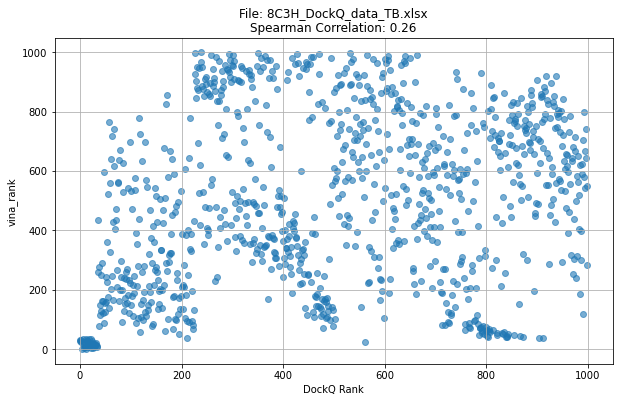

File: 8C3H_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.2551734511734512



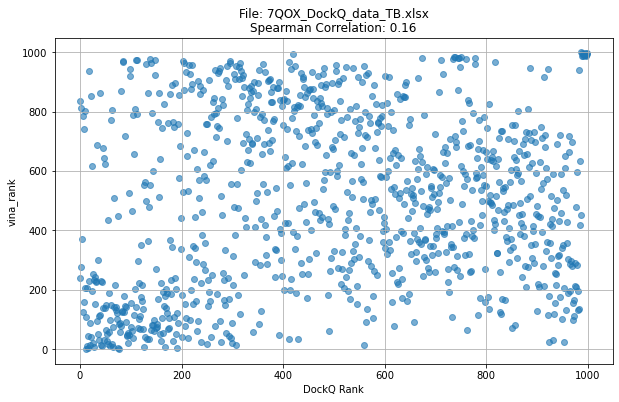

File: 7QOX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.15845580245580249



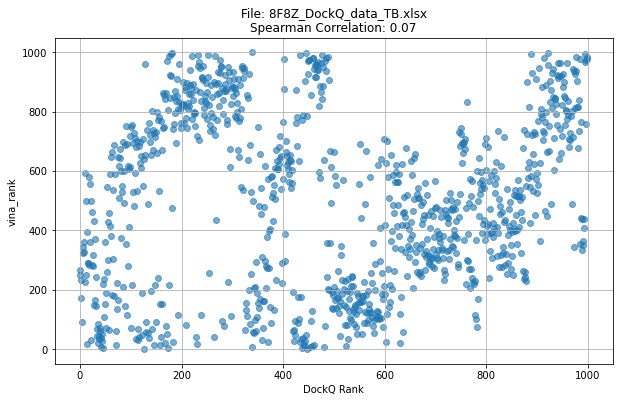

File: 8F8Z_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.07277086877086877



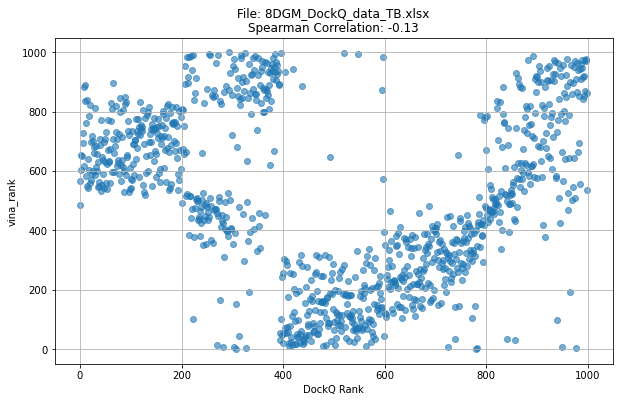

File: 8DGM_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.1334827454827455



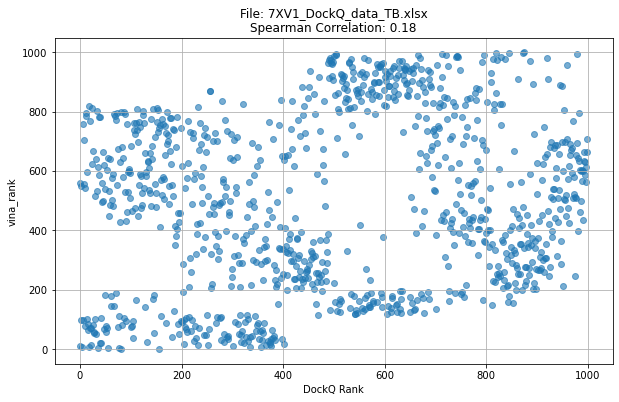

File: 7XV1_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.18033415233415234



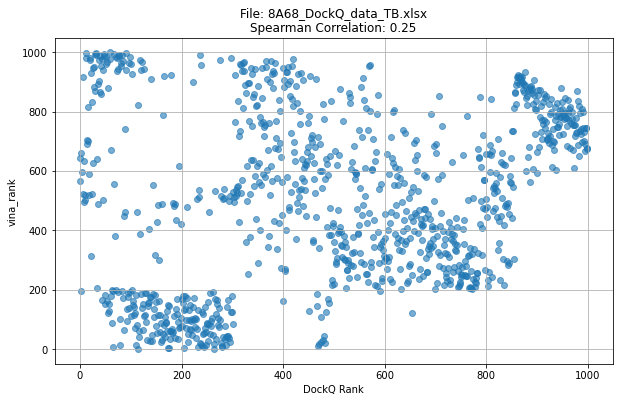

File: 8A68_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.2472961392961393



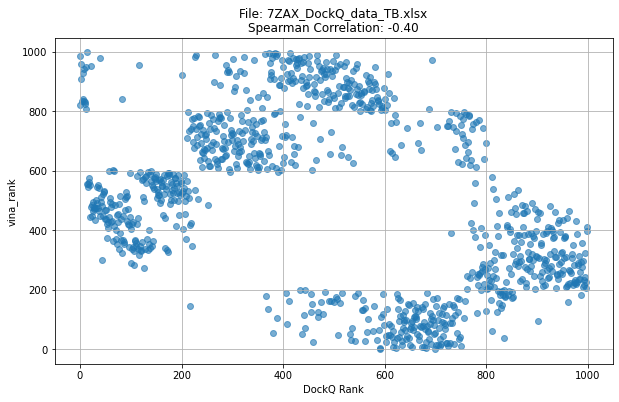

File: 7ZAX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4023906070399056



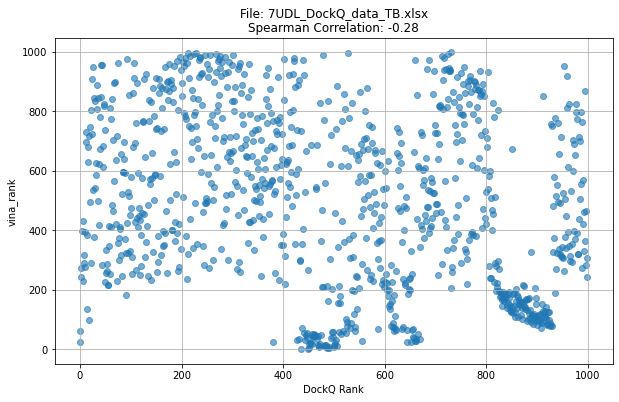

File: 7UDL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.28353469702167095



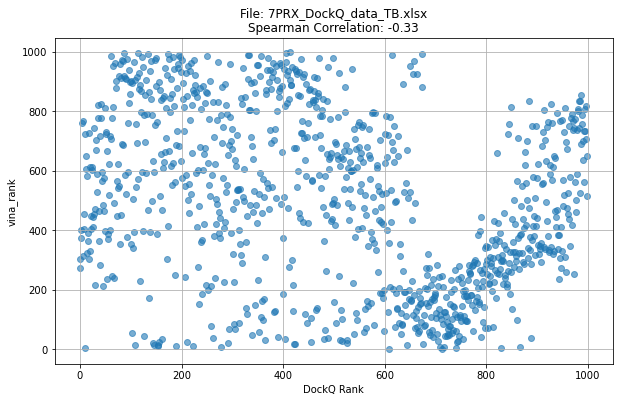

File: 7PRX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.3294617102072011



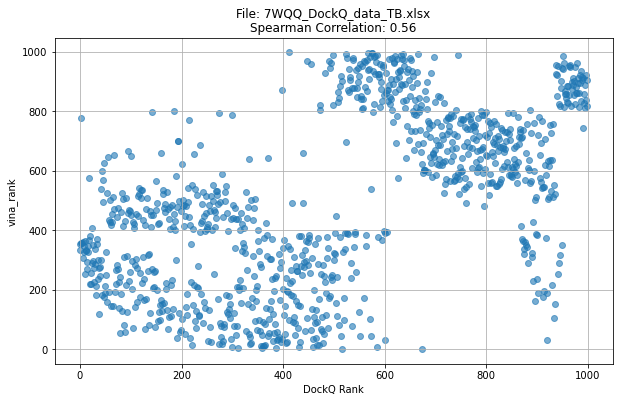

File: 7WQQ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5574152027779281



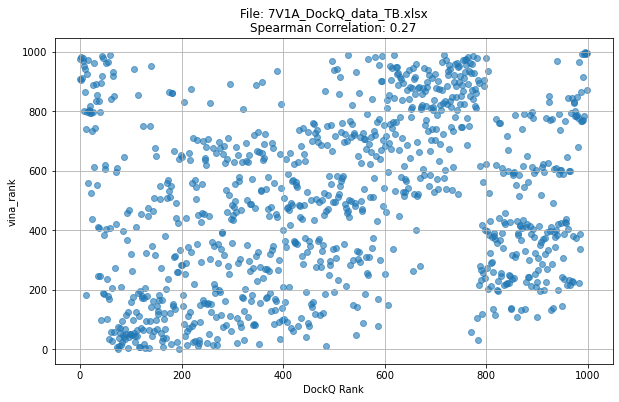

File: 7V1A_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.27275784000433295



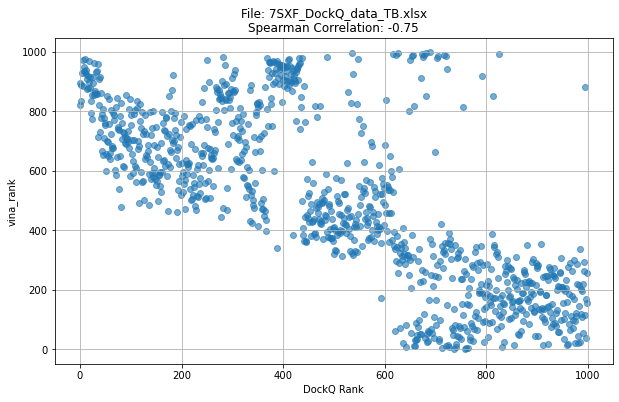

File: 7SXF_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7515641613557443



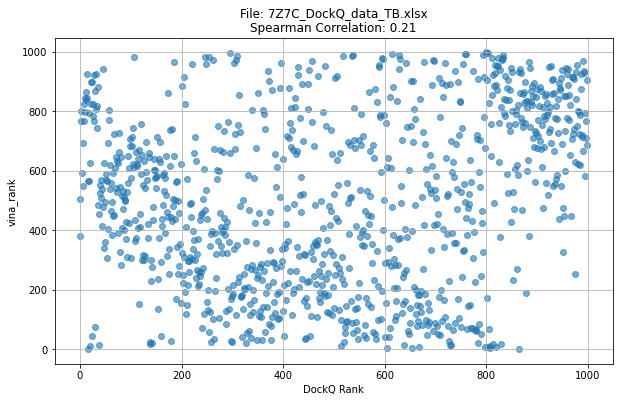

File: 7Z7C_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.21291175744883156



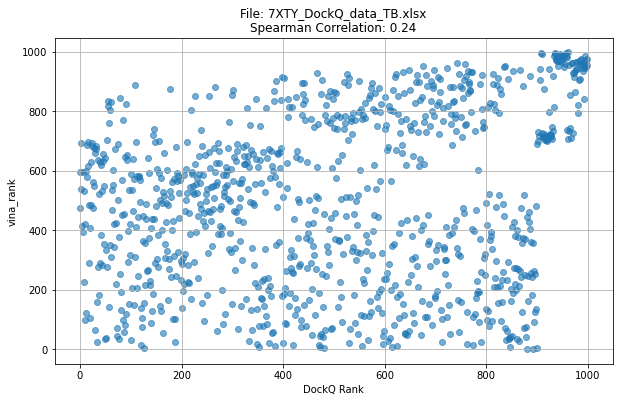

File: 7XTY_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.2407372703364687



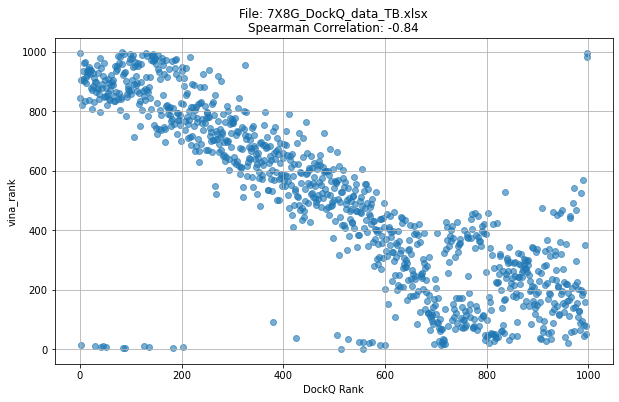

File: 7X8G_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.8376005223660532



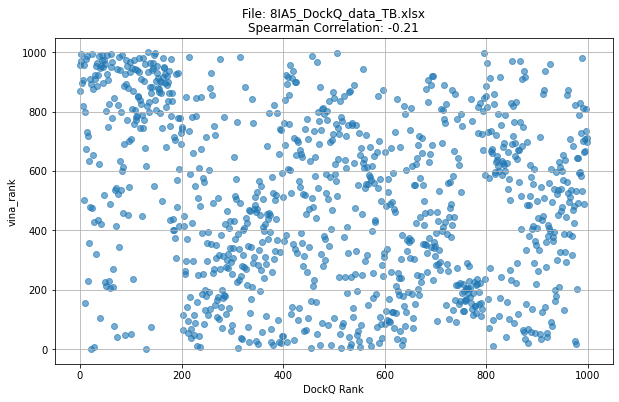

File: 8IA5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.208973668973669



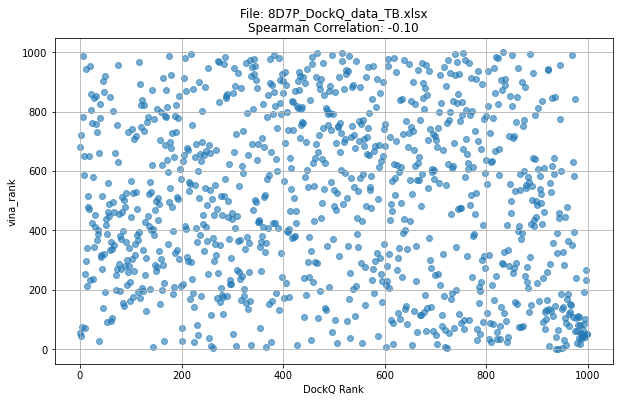

File: 8D7P_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.09512783912783913



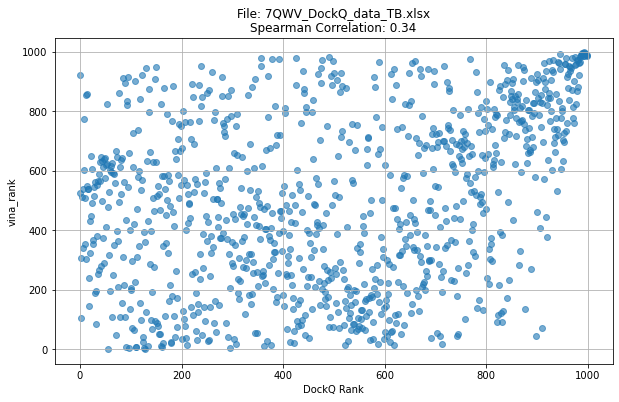

File: 7QWV_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.3371939915867771



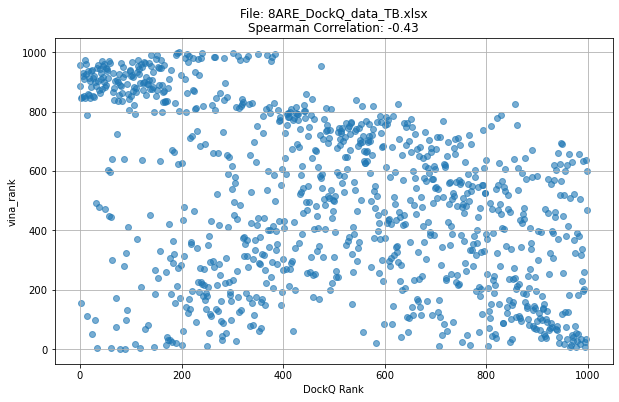

File: 8ARE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.42935301335301335



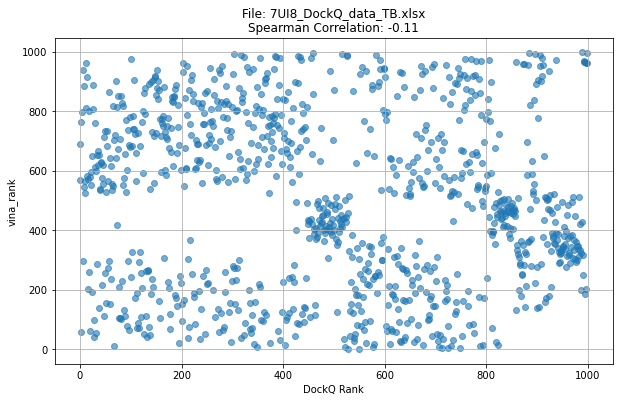

File: 7UI8_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.11476956315032465



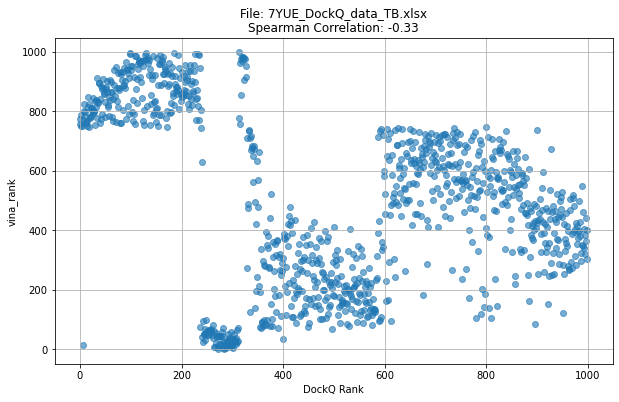

File: 7YUE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.32859631575463233



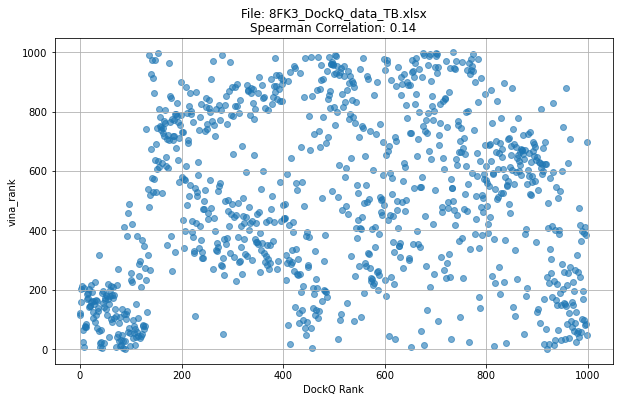

File: 8FK3_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.14215785415785417



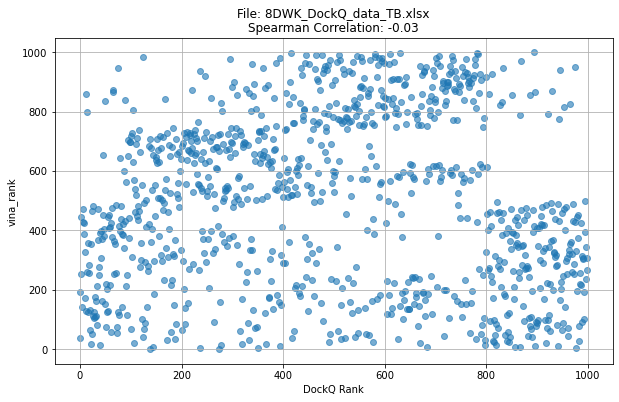

File: 8DWK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.02599876999877



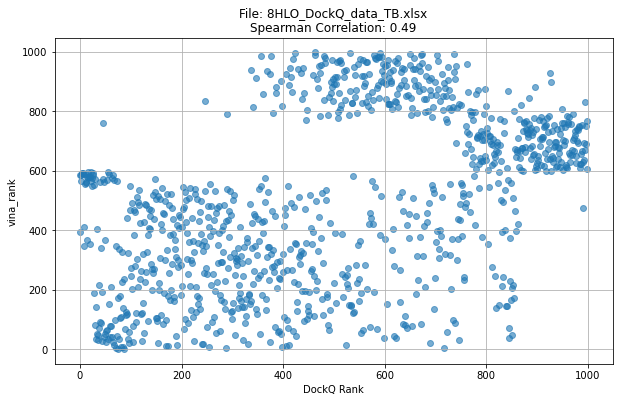

File: 8HLO_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.48762937285983365



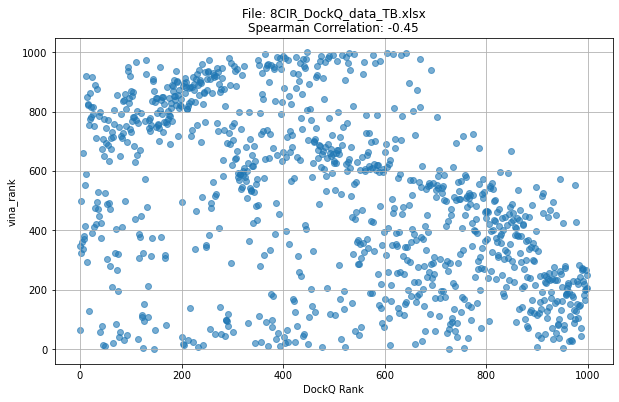

File: 8CIR_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.45298085698085694



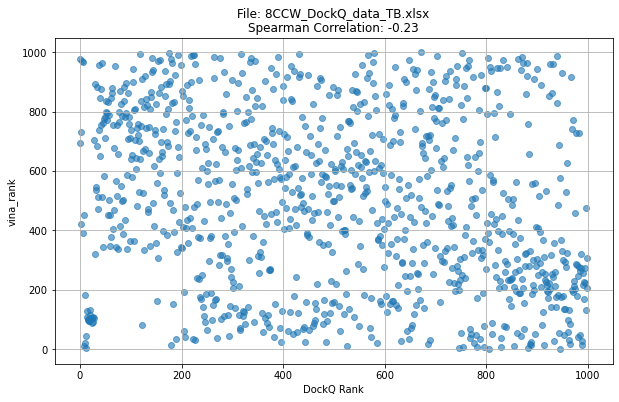

File: 8CCW_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.2311476871476872



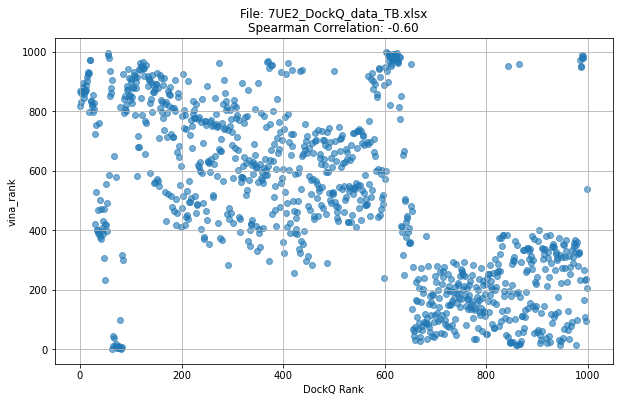

File: 7UE2_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.601377963133474



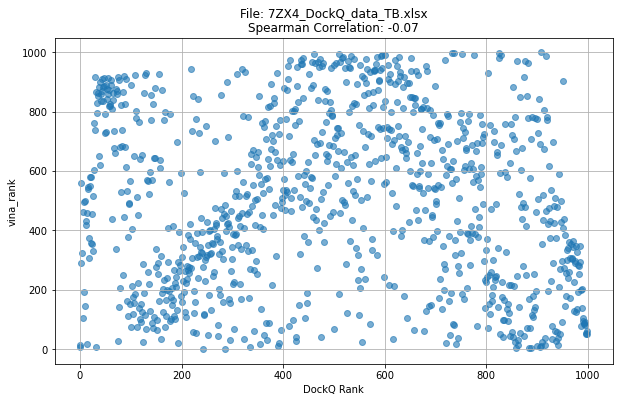

File: 7ZX4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.06691722691722692



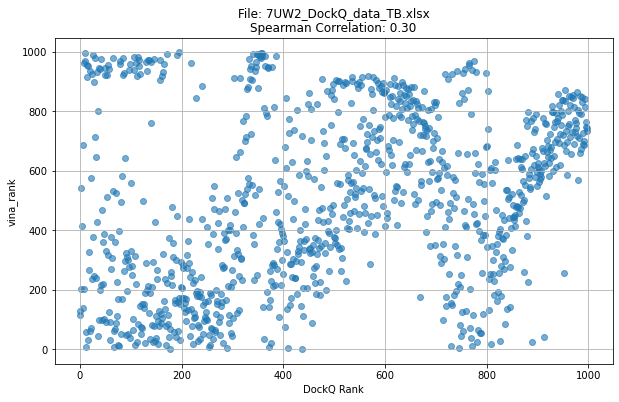

File: 7UW2_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.3023657525260731



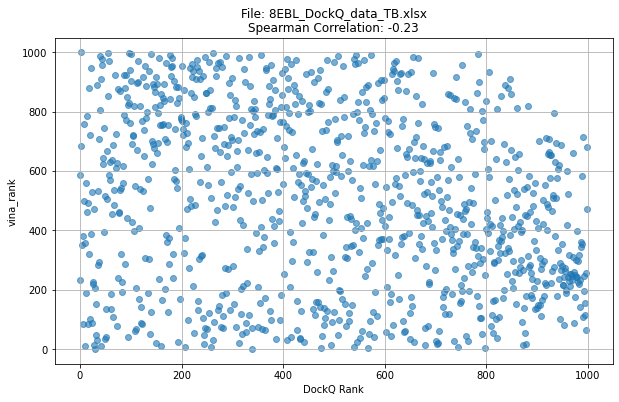

File: 8EBL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.22661543861543862



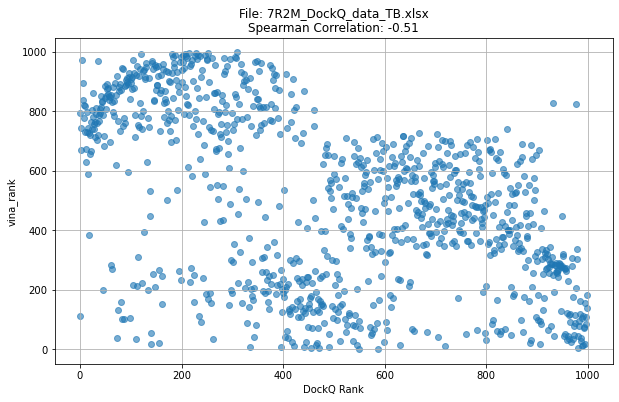

File: 7R2M_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5125793328398538



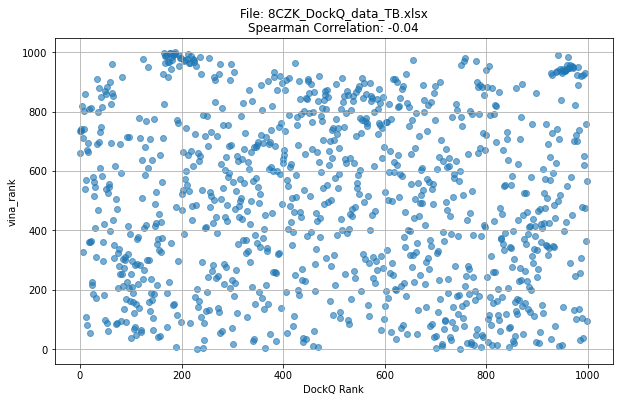

File: 8CZK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.043247095247095246



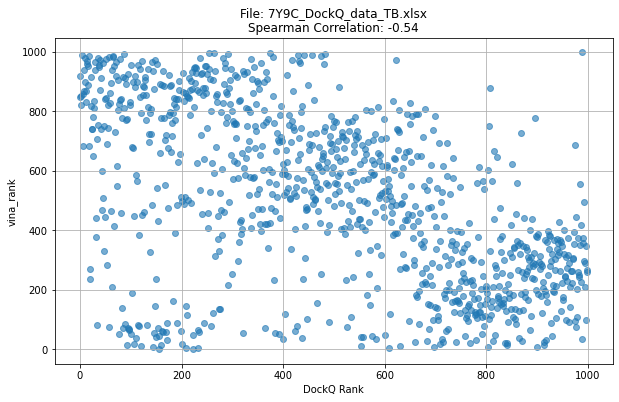

File: 7Y9C_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5363495519567664



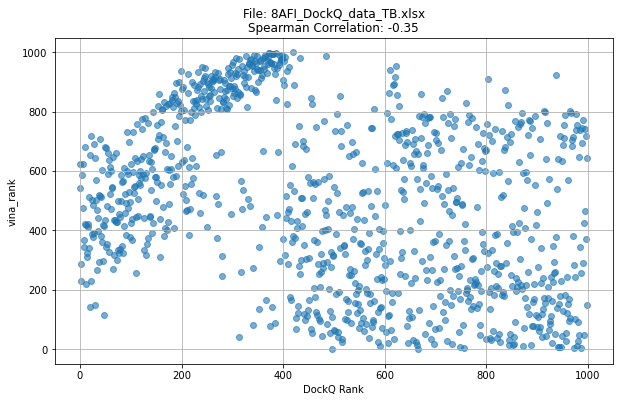

File: 8AFI_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.34737549537549545



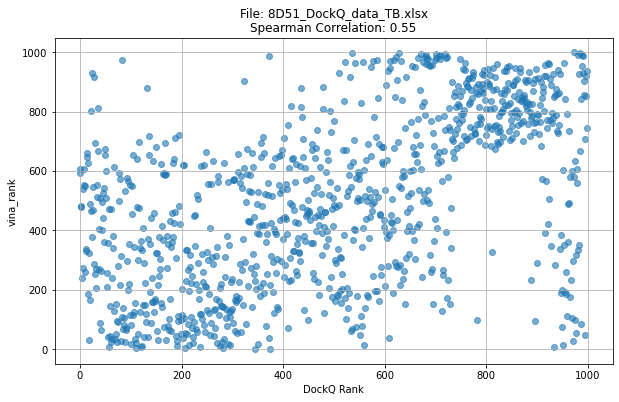

File: 8D51_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5549814509814509



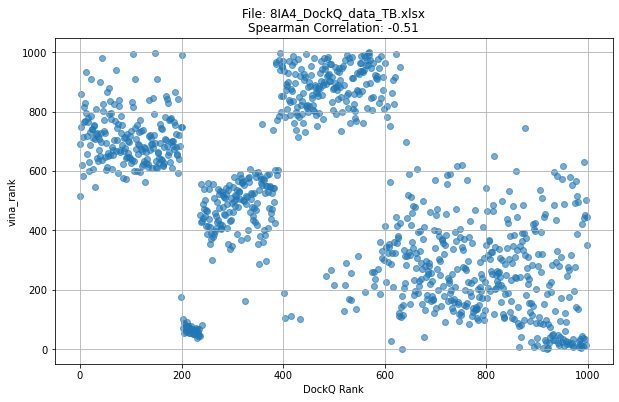

File: 8IA4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5101572901572902



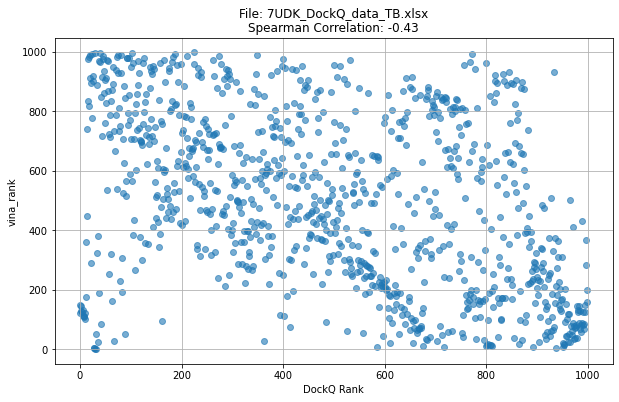

File: 7UDK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.43371819916108484



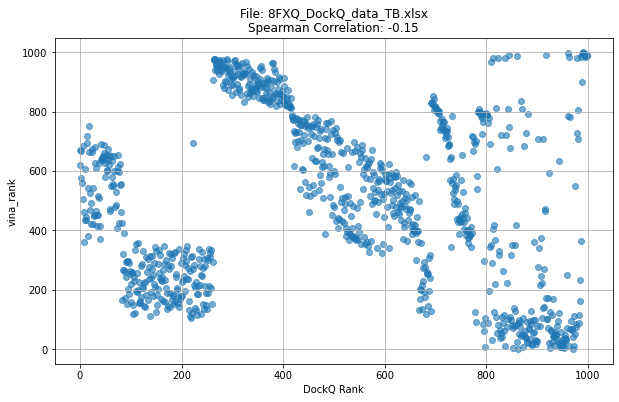

File: 8FXQ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.147978327978328



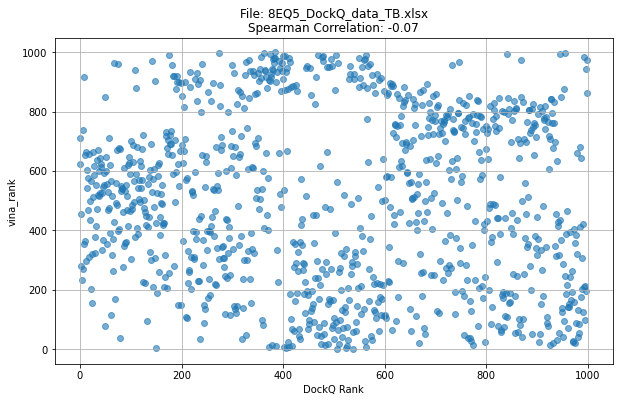

File: 8EQ5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.06883392883392883



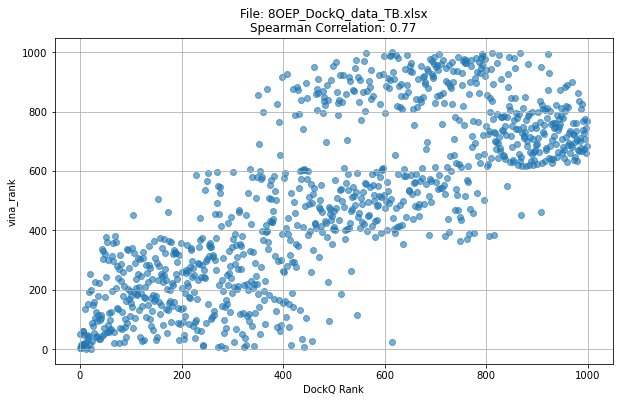

File: 8OEP_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.7726515766515768



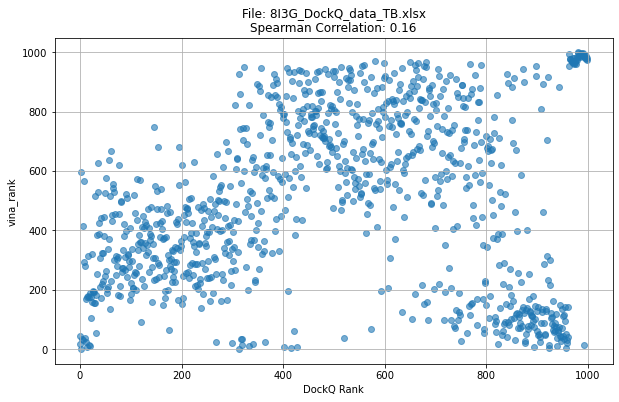

File: 8I3G_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.16368966768966772



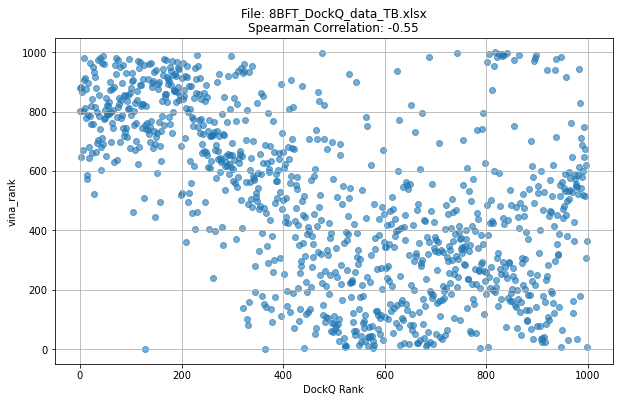

File: 8BFT_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5476933396933397



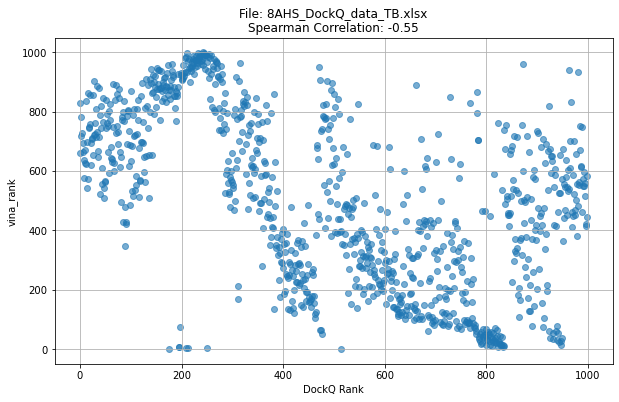

File: 8AHS_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.554918606918607



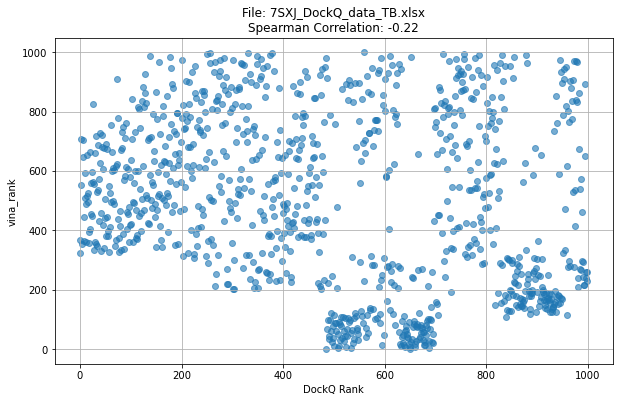

File: 7SXJ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.22191545391545395



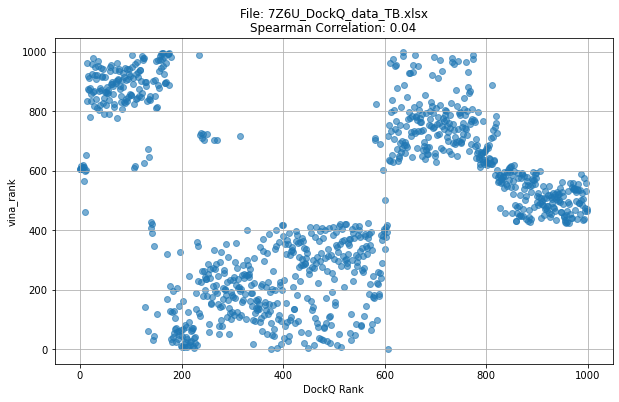

File: 7Z6U_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.04179396631100037



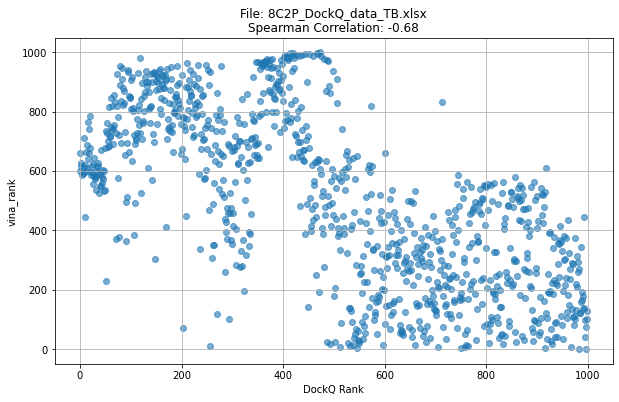

File: 8C2P_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.6826585666585666



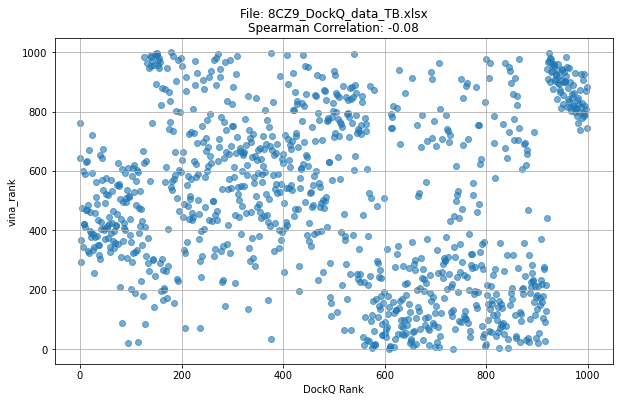

File: 8CZ9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.07757956157956158



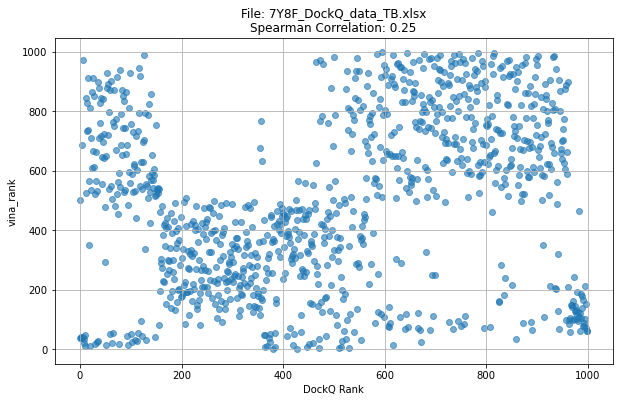

File: 7Y8F_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.24610077813284226



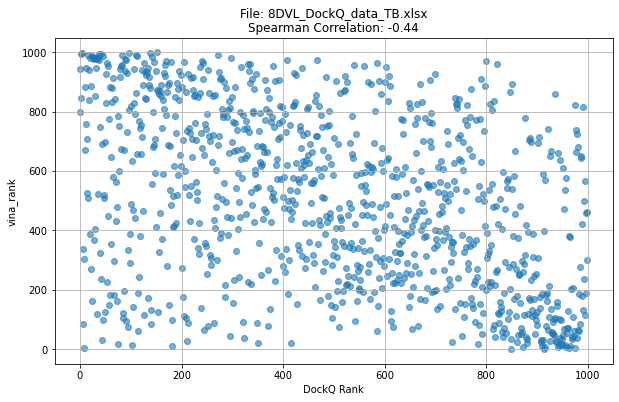

File: 8DVL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.43788623388623393



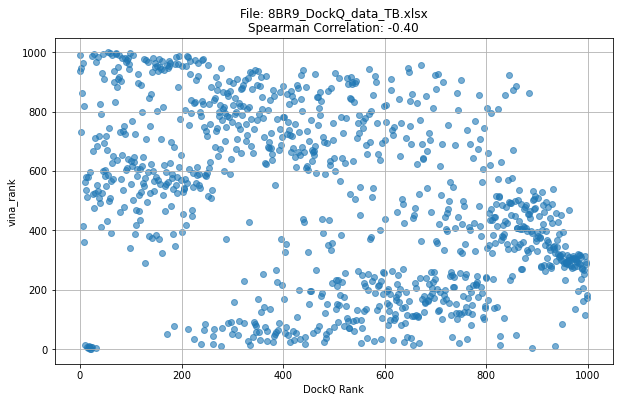

File: 8BR9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.40278399078399085



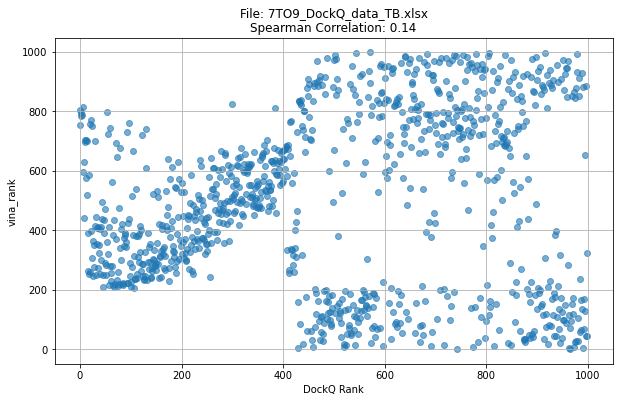

File: 7TO9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.14417638881366335



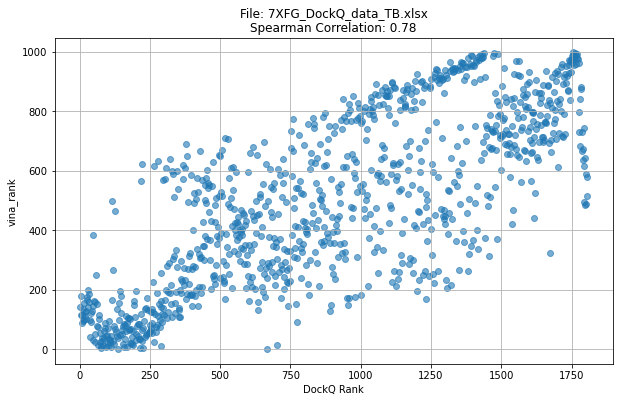

File: 7XFG_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.7752276685503137



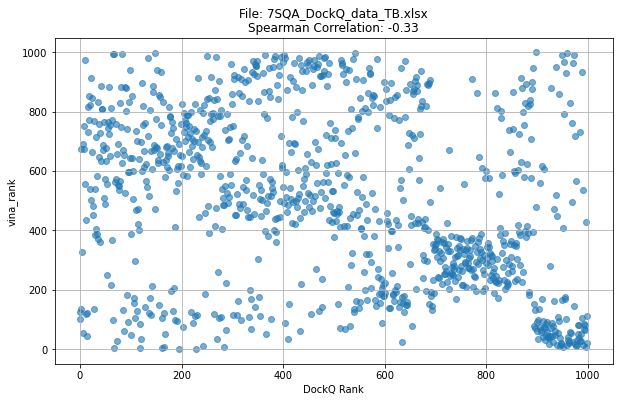

File: 7SQA_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.3294652974652975



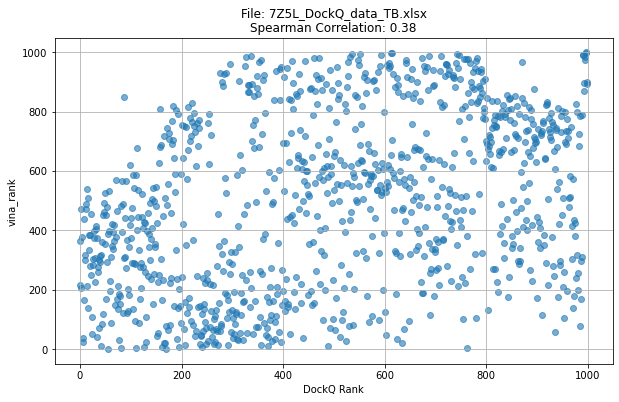

File: 7Z5L_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.3800829440829441



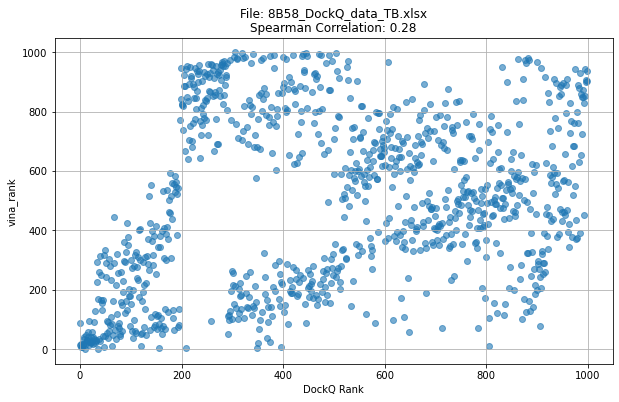

File: 8B58_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.28477107277107283



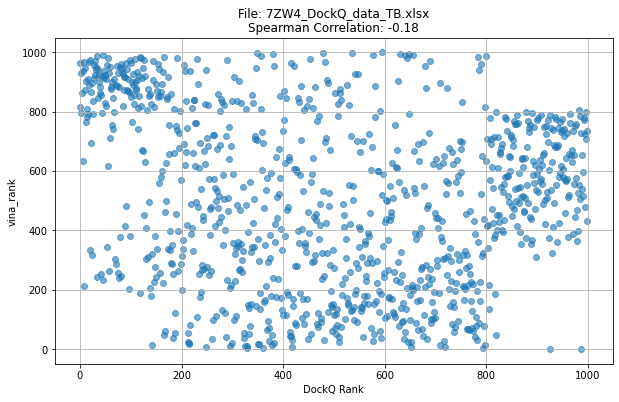

File: 7ZW4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.18345378345378346

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman/correlations_vina_TB.xlsx


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Vina' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Vina" sheet.')
            continue

        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        pyrosetta_df = pd.read_excel(excel_file_path, sheet_name='Vina')
        
        pyrosetta_rank_column = 'vina_rank'
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        pyrosetta_df['DockQ Rank'] = pyrosetta_df['alphafold rank'].map(alpha_to_dockq_map)
        
        filtered_pyrosetta_df = pyrosetta_df.dropna(subset=['DockQ Rank'])
        
        spearman_corr, _ = spearmanr(filtered_pyrosetta_df[pyrosetta_rank_column], filtered_pyrosetta_df['DockQ Rank'])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_pyrosetta_df['DockQ Rank'], filtered_pyrosetta_df[pyrosetta_rank_column], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('vina_rank')
        plt.grid(True)
        plt.show()

        # Append file name and Spearman correlation to the list
        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
        print(f'File: {excel_file}\nSpearman Correlation Coefficient: {spearman_corr}\n')
    
    # Convert list to DataFrame
    correlations_df = pd.DataFrame(correlations)
    
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Path for the new Excel file
    output_file_path = os.path.join(output_directory, 'correlations_vina_TB.xlsx')
    
    # Save DataFrame to an Excel file
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')

# Example usage
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/vina_DockQ_TB'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman'
process_excel_files(directory_path, output_directory)




In [6]:
import pandas as pd

def calculate_positive_negative_percentages(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Pyros_Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    return positive_percentage, negative_percentage

# Example usage
file_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman/correlations_vina_TB.xlsx'  # Replace with the actual path to your Excel file
positive_percentage, negative_percentage = calculate_positive_negative_percentages(file_path)
print(f"Positive Vina_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Vina_Spearman Correlation: {negative_percentage:.2f}%")



Positive Vina_Spearman Correlation: 39.29%
Negative Vina_Spearman Correlation: 60.71%


In [7]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Autodock_Vina/Data/vina_DockQ_TB'

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path)

    # Extract pdb_id from file name
    pdb_id = file_name.split('_')[0]

    # Load data from "Foldx" sheet
    foldx_df = pd.read_excel(file_path, sheet_name='Vina')
    #structure_name_for_rank_zero = foldx_df[foldx_df['vina_rank'] == 0]['file'].iloc[0].replace('_clean.pdb', '')
    structure_name_for_rank_zero = foldx_df[foldx_df['vina_rank'] == 0]['file'].iloc[0].replace('.pdb', '.pdb_clean')

    # Load data from "Sheet" sheet
    sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

    # Highest DockQ score
    highest_dockq_score = sheet_df['DockQ'].max()

    # DockQ score for the structure from Foldx
    highest_foldx_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

    # Calculate Loss
    score_Loss = highest_dockq_score - highest_foldx_dockq_score

    # Append results
    results.append([pdb_id, highest_dockq_score, highest_foldx_dockq_score, score_Loss])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Vina ranked', 'Loss'])

# Save the results into a new Excel file
output_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TB_Loss/Vina_loss_TB.xlsx'
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")



Results have been saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TB_Loss/Vina_loss_TB.xlsx
